# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [40]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional
from joblib import Parallel, delayed


#### Run with GPU


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Load

In [3]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [4]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
10329,Dermatitis,The discomfort in my skin has made it challeng...
10330,Dermatitis,"The raw, sensitive skin from scratching has ma..."
10331,Dermatitis,"I feel like my skin is tearing apart, causing ..."
10332,Dermatitis,Engaging in physical activities has become unb...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [6]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


<Axes: title={'center': 'Dataset balancing'}, xlabel='Disease'>

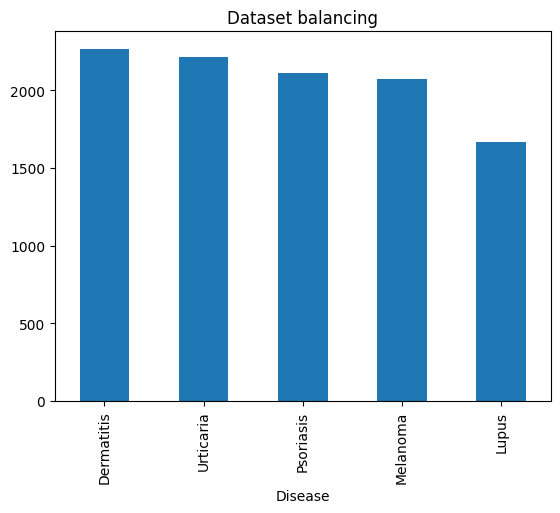

In [7]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

In [8]:
words = set()

for sentence in data['User_input']:
    for word in sentence.split():
        words.add(word)

num_unique_words = len(words)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 4631


## Model Evaluation

In [9]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    
    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [10]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [11]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

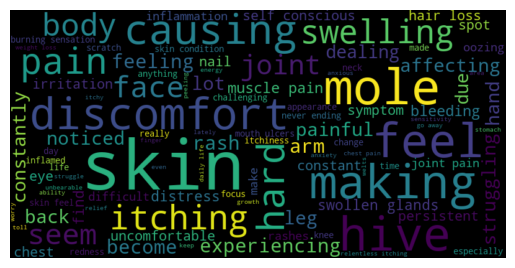

In [12]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

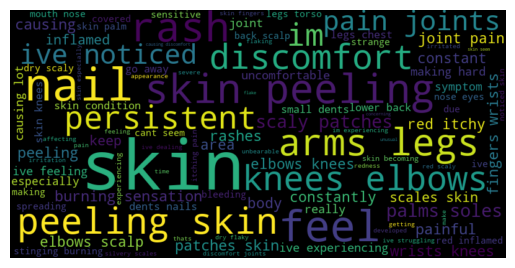

In [13]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

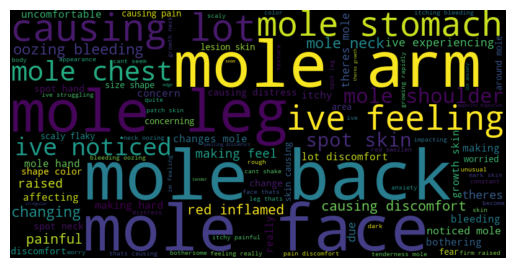

In [14]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

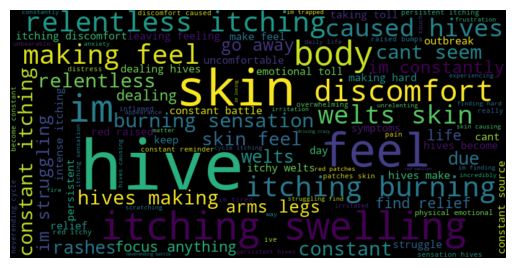

In [15]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

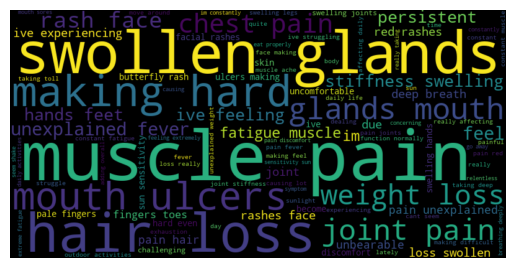

In [16]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

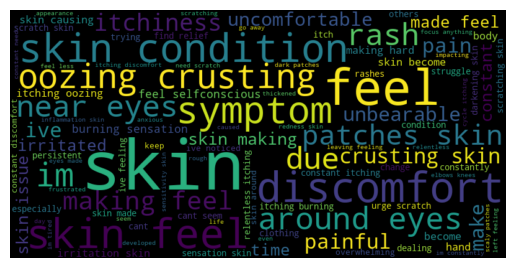

In [17]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [18]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [19]:
#nltk.download('wordnet')

In [20]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [21]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [22]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [23]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
0,Psoriasis,"[I, have, been, experiencing, a, skin, rash, o...","[experiencing, skin, rash, arms, legs, torso, ...","[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"[My, skin, has, been, peeling,, especially, on...","[my, skin, peeling, especially, knees, elbows,...","[my, skin, peel, especi, knee, elbow, scalp, t...","[my, skin, peeling, especially, knee, elbow, s..."
2,Psoriasis,"[I, have, been, experiencing, joint, pain, in,...","[experiencing, joint, pain, fingers, wrists, k...","[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"[There, is, a, silver, like, dusting, on, my, ...","[there, silver, like, dusting, skin, especiall...","[there, silver, like, dust, skin, especi, lowe...","[there, silver, like, dusting, skin, especiall..."
4,Psoriasis,"[My, nails, have, small, dents, or, pits, in, ...","[my, nails, small, dents, pits, them, often, f...","[my, nail, small, dent, pit, them, often, feel...","[my, nail, small, dent, pit, them, often, feel..."
...,...,...,...,...,...
10329,Dermatitis,"[The, discomfort, in, my, skin, has, made, it,...","[the, discomfort, skin, made, challenging, par...","[the, discomfort, skin, made, challeng, partak...","[the, discomfort, skin, made, challenging, par..."
10330,Dermatitis,"[The, raw,, sensitive, skin, from, scratching,...","[the, raw, sensitive, skin, scratching, made, ...","[the, raw, sensit, skin, scratch, made, unbear...","[the, raw, sensitive, skin, scratching, made, ..."
10331,Dermatitis,"[I, feel, like, my, skin, is, tearing, apart,,...","[feel, like, skin, tearing, apart, causing, ex...","[feel, like, skin, tear, apart, caus, excruci,...","[feel, like, skin, tearing, apart, causing, ex..."
10332,Dermatitis,"[Engaging, in, physical, activities, has, beco...","[engaging, physical, activities, become, unbea...","[engag, physic, activ, becom, unbear, due, sen...","[engaging, physical, activity, become, unbeara..."


## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [24]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [25]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(4,4))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [26]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))


In [27]:
#Smoothing to avoid 0 probabilities
#data_tfidf = data_tfidf + 1

# Normalize
#data_tfidf = data_tfidf.div(data_tfidf.sum(axis=1), axis=0)

#display(data_tfidf)

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [28]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 5 columns.
Test dataset contains 2067 rows and 5 columns.


In [29]:
display(train)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
4880,Urticaria,"[I'm, struggling, to, find, moments, of, peace...","[im, struggling, find, moments, peace, amidst,...","[im, struggl, find, moment, peac, amidst, chao...","[im, struggling, find, moment, peace, amidst, ..."
6651,Lupus,"[My, sensitivity, to, sunlight, is, causing, m...","[my, sensitivity, sunlight, causing, lot, disc...","[my, sensit, sunlight, caus, lot, discomfort, ...","[my, sensitivity, sunlight, causing, lot, disc..."
6451,Urticaria,"[The, hives, have, disrupted, every, aspect, o...","[the, hives, disrupted, every, aspect, life, w...","[the, hive, disrupt, everi, aspect, life, work...","[the, hive, disrupted, every, aspect, life, wo..."
4157,Melanoma,"[I've, recently, noticed, this, growth, on, my...","[ive, recently, noticed, growth, leg, causing,...","[ive, recent, notic, growth, leg, caus, lot, t...","[ive, recently, noticed, growth, leg, causing,..."
828,Psoriasis,"[I, struggle, with, painful, swelling, in, my,...","[struggle, painful, swelling, joints, daily]","[struggl, pain, swell, joint, daili]","[struggle, painful, swelling, joint, daily]"
...,...,...,...,...,...
5734,Urticaria,"[The, hives, on, my, skin, have, caused, such,...","[the, hives, skin, caused, intense, itching, s...","[the, hive, skin, caus, intens, itch, swell, l...","[the, hive, skin, caused, intense, itching, sw..."
5191,Urticaria,"[The, itching, and, swelling, have, become, a,...","[the, itching, swelling, become, constant, sou...","[the, itch, swell, becom, constant, sourc, str...","[the, itching, swelling, become, constant, sou..."
5390,Urticaria,"[It, feels, like, I'm, living, in, a, body, th...","[it, feels, like, im, living, body, thats, hij...","[it, feel, like, im, live, bodi, that, hijack,...","[it, feel, like, im, living, body, thats, hija..."
860,Psoriasis,"[I'm, frustrated, by, the, visible, scales, th...","[im, frustrated, visible, scales, formed, body]","[im, frustrat, visibl, scale, form, bodi]","[im, frustrated, visible, scale, formed, body]"


#### Define X

##### BoW

In [30]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Ngram

In [31]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [32]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [33]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [71]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [72]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [73]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [74]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [75]:
name = "LR_withoutyproc_"

**BoW** 

100%|██████████| 50/50 [00:11<00:00,  4.18trial/s, best loss: -0.7331549174817542]
Best hyperparameters: {'C': 3.424174241178451, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7812
Specificity Score: 0.7812
Precision Score: 0.7881
F1 Score: 0.7802

Testing Results
Accuracy Score: 0.7175
Specificity Score: 0.7175
Precision Score: 0.7250
F1 Score: 0.7168

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.72      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.78      0.57      0.66      1668
   Urticaria       0.67      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.79      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

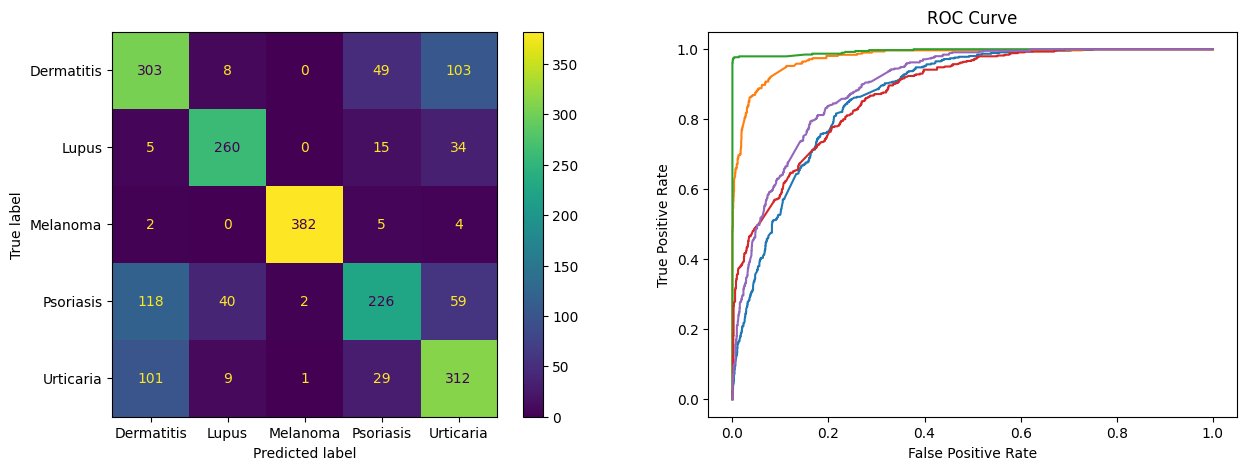

In [76]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [77]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

KeyboardInterrupt: 

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [ ]:
name = "LR_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [ ]:
name = "LR_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### With stemming

In [ ]:
name = "LR_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [84]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Random Search ####

In [97]:
def random_search_nb(X_train):
    param_grid = {
        'alpha': np.random.uniform(0.0, 2.0, 50),
        'fit_prior': [True, False],
        'class_prior': [None] + [np.random.dirichlet(np.ones(np.unique(y_train).shape[0])) for _ in range(50)]
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return score

    num_iterations = 50
    for _ in range(num_iterations):
        params = {k: np.random.choice(v) if k != 'class_prior' else v[np.random.randint(len(v))] for k, v in param_grid.items()}
        score = evaluate_params(params)
        if score > best_score:
            best_score = score
            best_params = params
    
    print("Best hyperparameters:", best_params)
    return best_params


##### Run Model

In [100]:
def model_nb(best_param, X_train, X_test, model_type):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [101]:
name = "NB_withoutyproc_"

**BoW** 

Best hyperparameters: {'alpha': 0.7341786214047077, 'fit_prior': False, 'class_prior': array([0.34634689, 0.10818254, 0.0510356 , 0.17430971, 0.32012525])}
Training Results
Accuracy Score: 0.7357
Specificity Score: 0.7357
Precision Score: 0.7616
F1 Score: 0.7367

Testing Results
Accuracy Score: 0.6759
Specificity Score: 0.6759
Precision Score: 0.7067
F1 Score: 0.6790

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.54      0.76      0.63      1803
       Lupus       0.88      0.78      0.83      1355
    Melanoma       0.98      0.96      0.97      1677
   Psoriasis       0.78      0.48      0.59      1668
   Urticaria       0.68      0.71      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.77      0.74      0.74      8267
weighted avg       0.76      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.47      

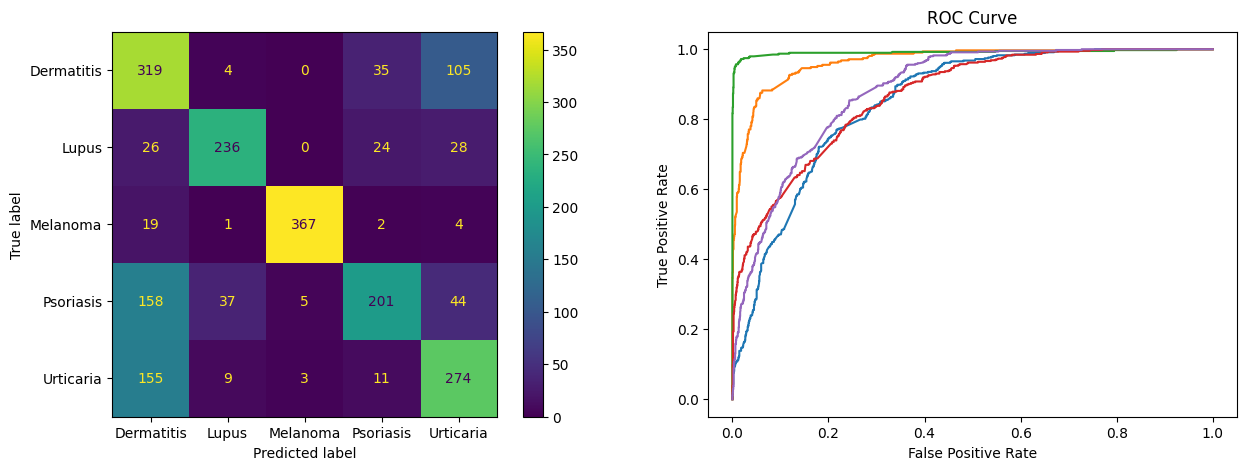

In [102]:
best_params = random_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**n-grams**

Best hyperparameters: {'alpha': 0.05258684120484558, 'fit_prior': False, 'class_prior': array([0.37138087, 0.03775979, 0.29249964, 0.11214202, 0.18621769])}
Training Results
Accuracy Score: 0.2572
Specificity Score: 0.2572
Precision Score: 0.8250
F1 Score: 0.1548

Testing Results
Accuracy Score: 0.2419
Specificity Score: 0.2419
Precision Score: 0.7177
F1 Score: 0.1188

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37      1803
       Lupus       1.00      0.09      0.17      1355
    Melanoma       1.00      0.05      0.10      1677
   Psoriasis       1.00      0.03      0.05      1668
   Urticaria       0.97      0.04      0.07      1764

    accuracy                           0.26      8267
   macro avg       0.84      0.24      0.15      8267
weighted avg       0.83      0.26      0.15      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23     

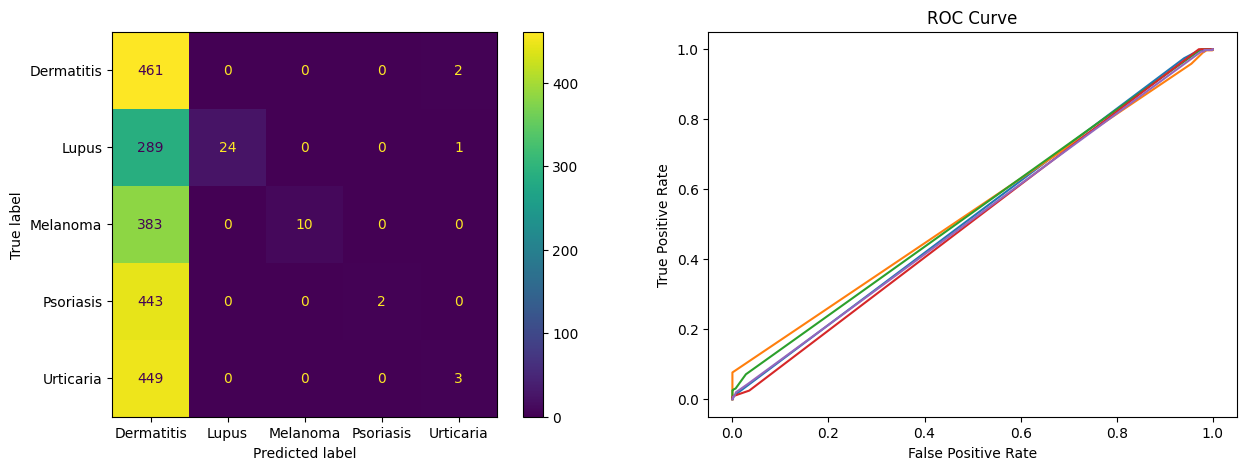

In [103]:
best_params = random_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 0.7028642818525628, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7552
Specificity Score: 0.7552
Precision Score: 0.7535
F1 Score: 0.7506

Testing Results
Accuracy Score: 0.7112
Specificity Score: 0.7112
Precision Score: 0.7084
F1 Score: 0.7059

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.65      0.66      1803
       Lupus       0.85      0.81      0.83      1355
    Melanoma       0.83      0.98      0.90      1677
   Psoriasis       0.75      0.58      0.65      1668
   Urticaria       0.70      0.78      0.74      1764

    accuracy                           0.76      8267
   macro avg       0.76      0.76      0.76      8267
weighted avg       0.75      0.76      0.75      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.61      0.60       463
       Lupus       0.80      0.76     

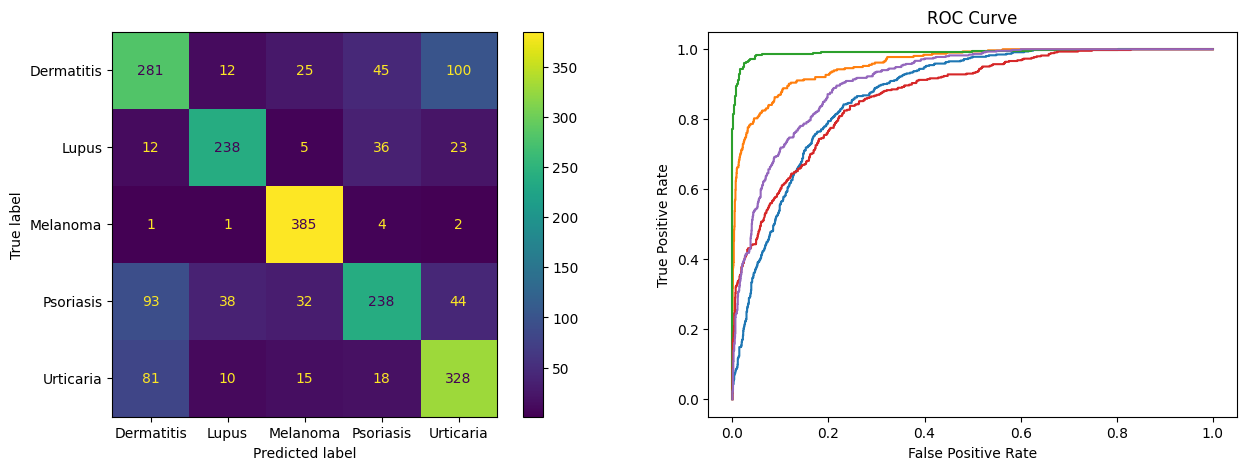

In [104]:
best_params = random_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [105]:
name = "NB_withproc_"

**BoW** 

Best hyperparameters: {'alpha': 0.3916943547016669, 'fit_prior': False, 'class_prior': array([0.17897876, 0.11660688, 0.25332795, 0.19194147, 0.25914493])}
Training Results
Accuracy Score: 0.7280
Specificity Score: 0.7280
Precision Score: 0.7325
F1 Score: 0.7228

Testing Results
Accuracy Score: 0.6894
Specificity Score: 0.6894
Precision Score: 0.6897
F1 Score: 0.6832

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.55      0.60      1803
       Lupus       0.88      0.79      0.83      1355
    Melanoma       0.87      0.98      0.92      1677
   Psoriasis       0.71      0.54      0.61      1668
   Urticaria       0.60      0.80      0.68      1764

    accuracy                           0.73      8267
   macro avg       0.74      0.73      0.73      8267
weighted avg       0.73      0.73      0.72      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      

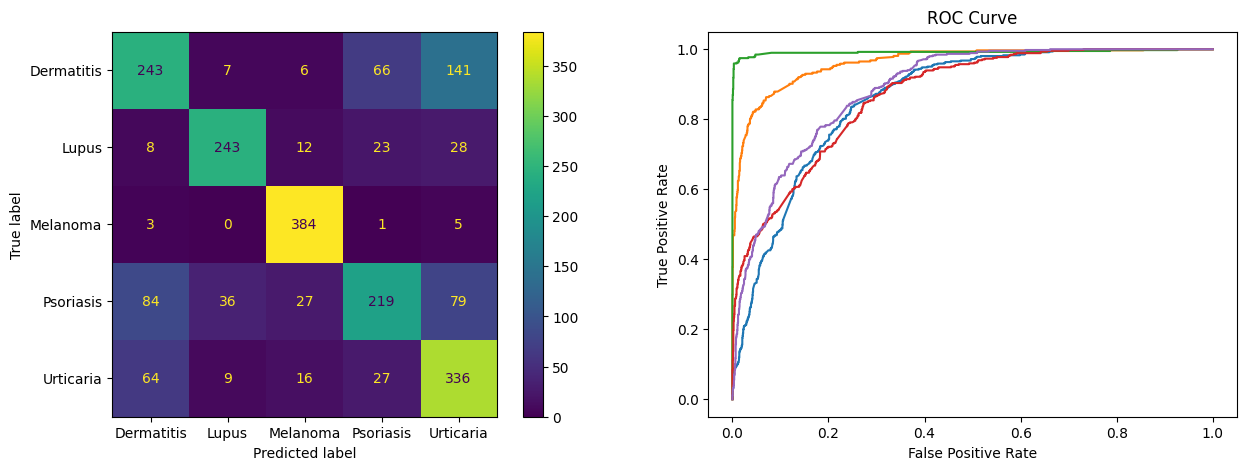

In [106]:
best_params = random_search_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

Best hyperparameters: {'alpha': 0.05583152426404703, 'fit_prior': False, 'class_prior': array([0.49548591, 0.04033384, 0.1000851 , 0.02755905, 0.33653609])}
Training Results
Accuracy Score: 0.2627
Specificity Score: 0.2627
Precision Score: 0.8110
F1 Score: 0.1665

Testing Results
Accuracy Score: 0.2453
Specificity Score: 0.2453
Precision Score: 0.7500
F1 Score: 0.1264

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37      1803
       Lupus       1.00      0.10      0.18      1355
    Melanoma       1.00      0.06      0.11      1677
   Psoriasis       1.00      0.03      0.05      1668
   Urticaria       0.90      0.06      0.11      1764

    accuracy                           0.26      8267
   macro avg       0.83      0.25      0.16      8267
weighted avg       0.81      0.26      0.17      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23     

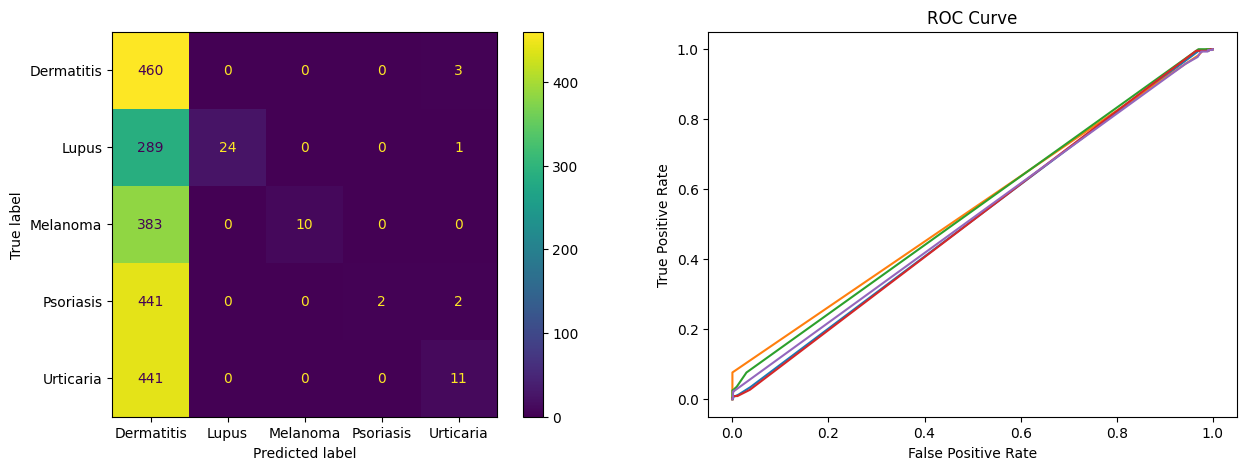

In [107]:
best_params = random_search_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [ ]:
name = "NB_lem_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### Witth stemming

In [ ]:
name = "NB_stem_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [61]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

In [62]:
def train_and_evaluate(params, X_train, y_train):
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

##### Random Search #####

In [63]:
def random_search_svm(X_train):
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        score = train_and_evaluate(params, X_train, y_train)
        return score

    num_iterations = 50
    num_jobs = 4  # Número de trabalhos em paralelo
    results = Parallel(n_jobs=num_jobs)(delayed(evaluate_params)({k: np.random.choice(v) for k, v in param_grid.items()}) for _ in range(num_iterations))
    
    best_index = np.argmax(results)
    best_params = {k: np.random.choice(v) for k, v in param_grid.items()}
    best_score = results[best_index]
    
    print("Best hyperparameters:", best_params)
    return best_params

##### Run Model

In [64]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(probability=True,C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['kernel'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [65]:
name = "SVM_withoutyproc_"

**BoW** 

Best hyperparameters: {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.6502
Specificity Score: 0.6502
Precision Score: 0.6857
F1 Score: 0.6462

Testing Results
Accuracy Score: 0.6207
Specificity Score: 0.6207
Precision Score: 0.6564
F1 Score: 0.6164

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.49      0.64      0.56      1803
       Lupus       0.81      0.71      0.76      1355
    Melanoma       1.00      0.94      0.97      1677
   Psoriasis       0.69      0.30      0.42      1668
   Urticaria       0.48      0.67      0.56      1764

    accuracy                           0.65      8267
   macro avg       0.70      0.65      0.65      8267
weighted avg       0.69      0.65      0.65      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.46      0.61      0.53       463
       Lupus       0.78      0.67      0.72       314
    Melanoma

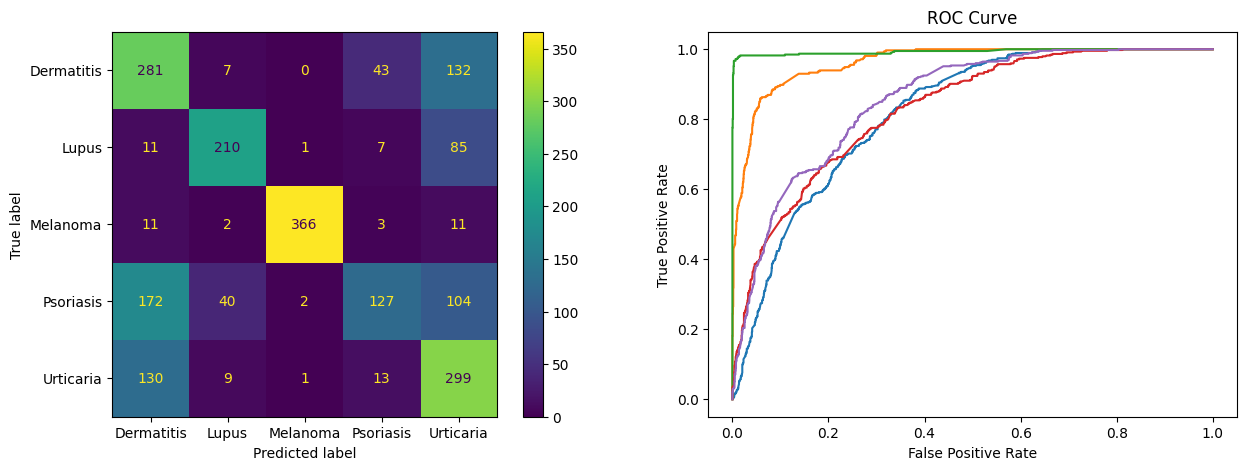

In [66]:
best_params = random_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**n-grams**

Best hyperparameters: {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2578
Specificity Score: 0.2578
Precision Score: 0.8019
F1 Score: 0.1567

Testing Results
Accuracy Score: 0.2414
Specificity Score: 0.2414
Precision Score: 0.6441
F1 Score: 0.1186

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37      1803
       Lupus       1.00      0.09      0.17      1355
    Melanoma       1.00      0.05      0.10      1677
   Psoriasis       0.92      0.03      0.06      1668
   Urticaria       0.93      0.04      0.08      1764

    accuracy                           0.26      8267
   macro avg       0.82      0.24      0.15      8267
weighted avg       0.80      0.26      0.16      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37       463
       Lupus       0.66      0.09      0.15       314
    Melanom

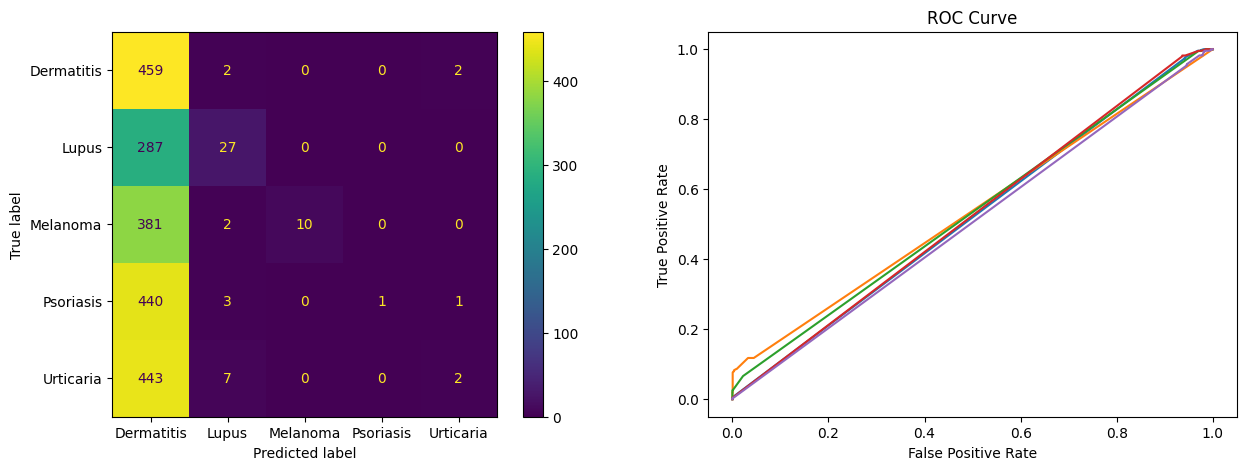

In [67]:
best_params = random_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.7668
Specificity Score: 0.7668
Precision Score: 0.7779
F1 Score: 0.7684

Testing Results
Accuracy Score: 0.7339
Specificity Score: 0.7339
Precision Score: 0.7481
F1 Score: 0.7354

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.61      0.75      0.67      1803
       Lupus       0.90      0.80      0.85      1355
    Melanoma       0.99      0.96      0.98      1677
   Psoriasis       0.72      0.58      0.64      1668
   Urticaria       0.71      0.75      0.73      1764

    accuracy                           0.77      8267
   macro avg       0.79      0.77      0.77      8267
weighted avg       0.78      0.77      0.77      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.57      0.74      0.64       463
       Lupus       0.86      0.75      0.80       314
    Melan

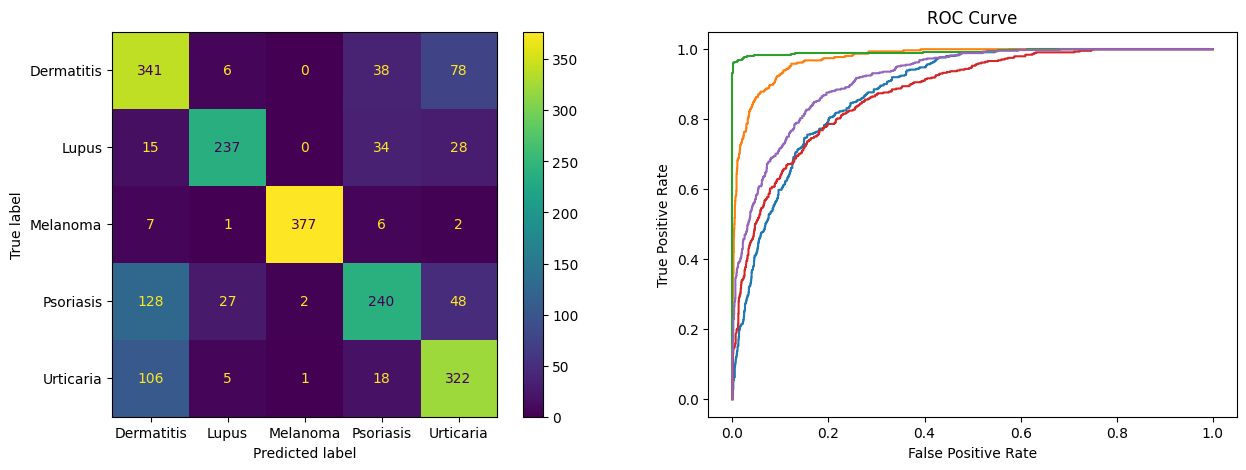

In [68]:
best_params = random_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [69]:
name = "SVM_withproc_"

**BoW** 

Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.6461
Specificity Score: 0.6461
Precision Score: 0.6696
F1 Score: 0.6453

Testing Results
Accuracy Score: 0.6202
Specificity Score: 0.6202
Precision Score: 0.6453
F1 Score: 0.6190

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.49      0.60      0.54      1803
       Lupus       0.80      0.74      0.77      1355
    Melanoma       1.00      0.91      0.95      1677
   Psoriasis       0.61      0.34      0.43      1668
   Urticaria       0.50      0.67      0.57      1764

    accuracy                           0.65      8267
   macro avg       0.68      0.65      0.65      8267
weighted avg       0.67      0.65      0.65      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.46      0.58      0.52       463
       Lupus       0.78      0.72      0.75       314
    Melanoma 

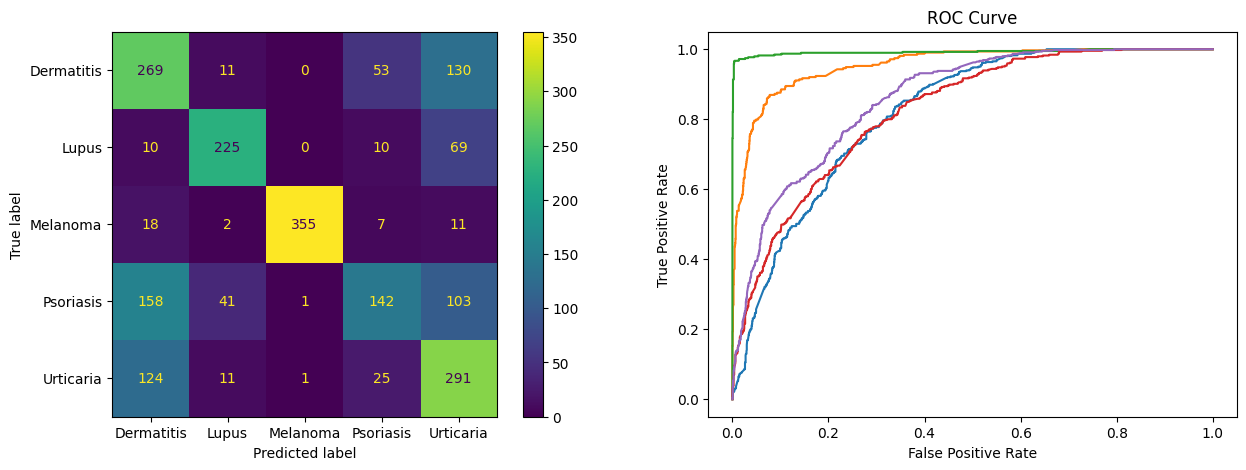

In [70]:
best_params = random_search_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

Best hyperparameters: {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2629
Specificity Score: 0.2629
Precision Score: 0.8110
F1 Score: 0.1668

Testing Results
Accuracy Score: 0.2463
Specificity Score: 0.2463
Precision Score: 0.7329
F1 Score: 0.1278

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37      1803
       Lupus       1.00      0.10      0.18      1355
    Melanoma       1.00      0.06      0.11      1677
   Psoriasis       1.00      0.03      0.05      1668
   Urticaria       0.90      0.06      0.11      1764

    accuracy                           0.26      8267
   macro avg       0.83      0.25      0.16      8267
weighted avg       0.81      0.26      0.17      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37       463
       Lupus       0.62      0.09      0.16       314
    Melanom

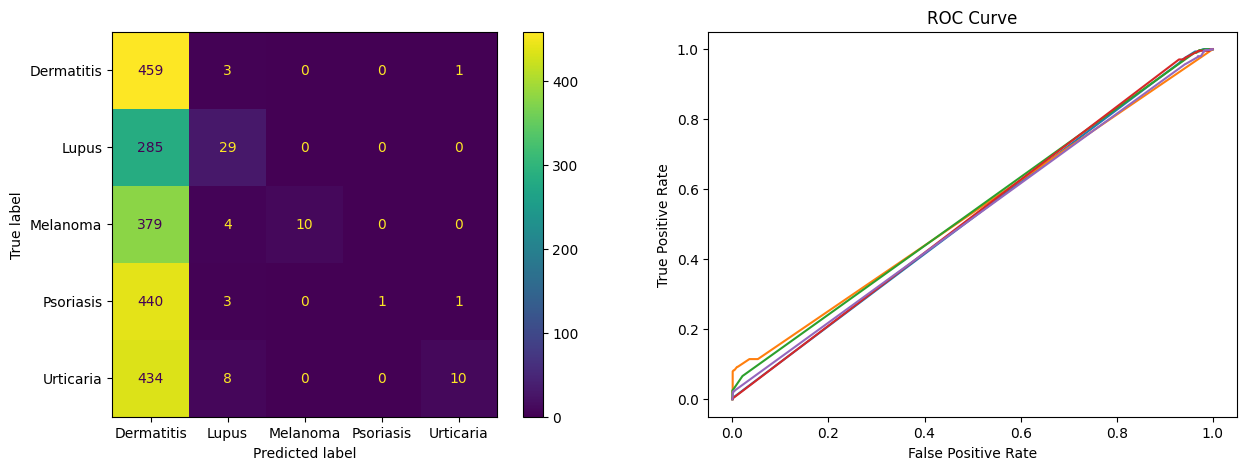

In [71]:
best_params = random_search_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8123
Specificity Score: 0.8123
Precision Score: 0.8138
F1 Score: 0.8119

Testing Results
Accuracy Score: 0.7223
Specificity Score: 0.7223
Precision Score: 0.7230
F1 Score: 0.7220

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.71      1803
       Lupus       0.88      0.90      0.89      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.79      0.68      0.73      1668
   Urticaria       0.73      0.79      0.76      1764

    accuracy                           0.81      8267
   macro avg       0.82      0.82      0.82      8267
weighted avg       0.81      0.81      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.63      0.61       463
       Lupus       0.80      0.83      0.81       314
    Mel

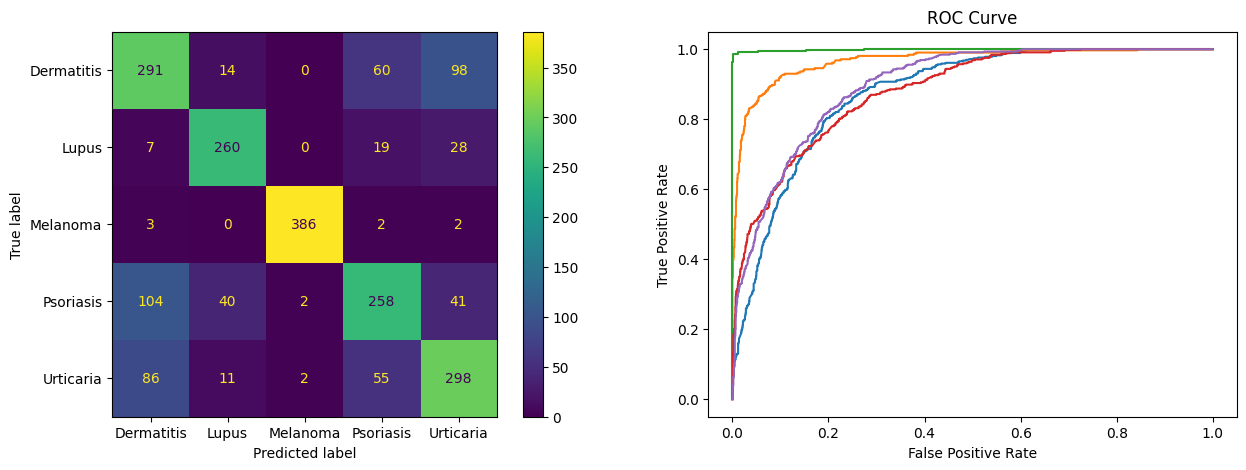

In [72]:
best_params = random_search_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [73]:
name = "SVM_lem_"

**BoW** 

Best hyperparameters: {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8822
Specificity Score: 0.8822
Precision Score: 0.8882
F1 Score: 0.8829

Testing Results
Accuracy Score: 0.8142
Specificity Score: 0.8142
Precision Score: 0.8258
F1 Score: 0.8158

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.75      0.88      0.81      1803
       Lupus       0.91      0.95      0.93      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.84      0.77      0.80      1668
   Urticaria       0.96      0.84      0.90      1764

    accuracy                           0.88      8267
   macro avg       0.89      0.89      0.89      8267
weighted avg       0.89      0.88      0.88      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.65      0.80      0.72       463
       Lupus       0.83      0.90      0.87       314
    

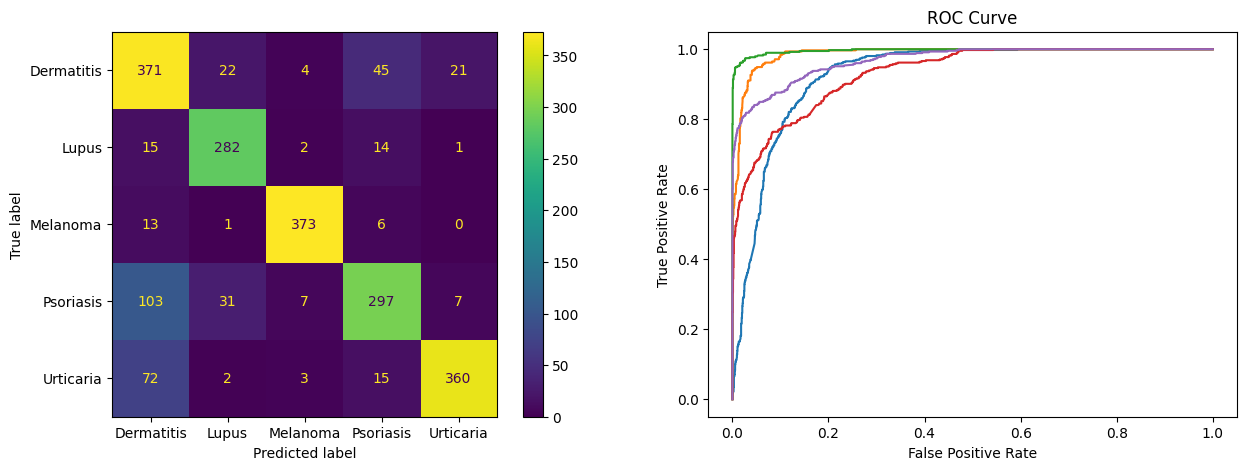

In [74]:
best_params = random_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2758
Specificity Score: 0.2758
Precision Score: 0.8089
F1 Score: 0.1852

Testing Results
Accuracy Score: 0.2719
Specificity Score: 0.2719
Precision Score: 0.8088
F1 Score: 0.1696

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.38      1803
       Lupus       1.00      0.19      0.33      1355
    Melanoma       1.00      0.01      0.02      1677
   Psoriasis       1.00      0.09      0.16      1668
   Urticaria       0.89      0.04      0.07      1764

    accuracy                           0.28      8267
   macro avg       0.82      0.26      0.19      8267
weighted avg       0.81      0.28      0.19      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.24      1.00      0.38       463
       Lupus       1.00      0.20      0.33       314
    Melan

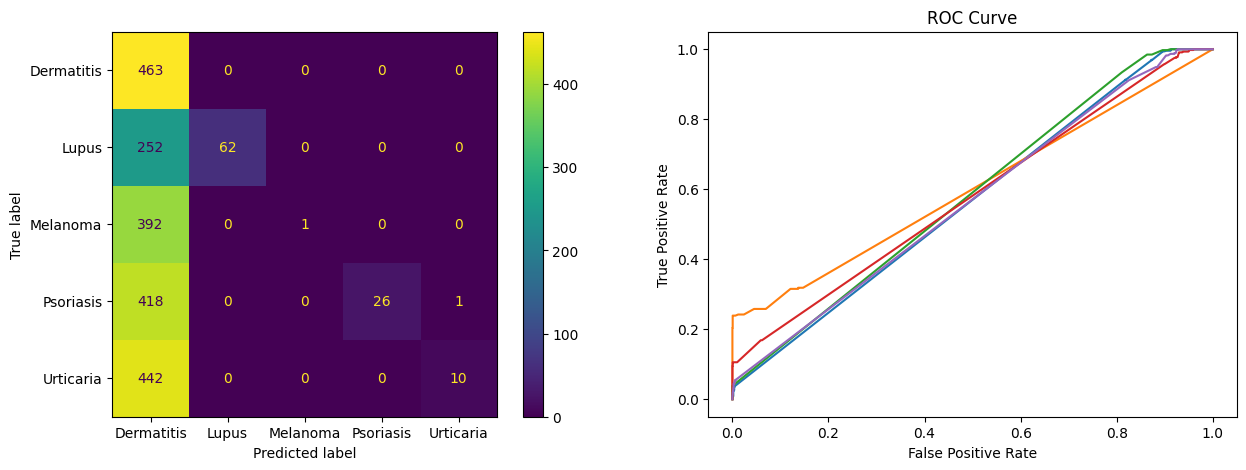

In [75]:
best_params = random_search_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9000
Specificity Score: 0.9000
Precision Score: 0.9031
F1 Score: 0.9004

Testing Results
Accuracy Score: 0.8162
Specificity Score: 0.8162
Precision Score: 0.8239
F1 Score: 0.8175

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.79      0.88      0.83      1803
       Lupus       0.94      0.96      0.95      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.87      0.80      0.84      1668
   Urticaria       0.95      0.88      0.91      1764

    accuracy                           0.90      8267
   macro avg       0.91      0.90      0.90      8267
weighted avg       0.90      0.90      0.90      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.66      0.78      0.72       463
       Lupus       0.84      0.90      0.87       314
    

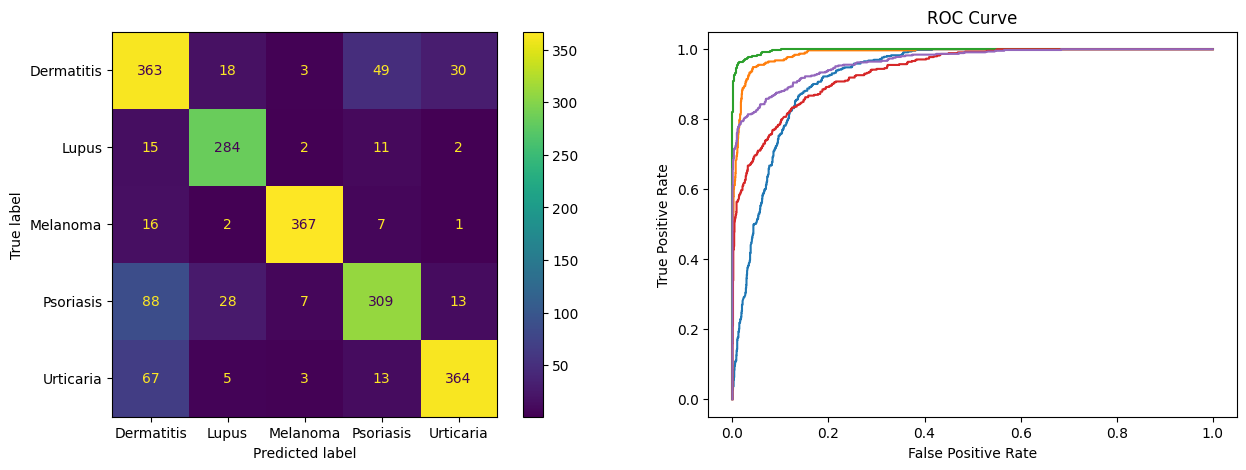

In [76]:
best_params = random_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### Witth stemming

In [77]:
name = "SVM_stem_"

**BoW** 

Best hyperparameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.8501
Specificity Score: 0.8501
Precision Score: 0.8734
F1 Score: 0.8528

Testing Results
Accuracy Score: 0.8365
Specificity Score: 0.8365
Precision Score: 0.8591
F1 Score: 0.8383

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.91      0.77      1803
       Lupus       0.90      0.95      0.92      1355
    Melanoma       0.99      0.93      0.96      1677
   Psoriasis       0.86      0.69      0.77      1668
   Urticaria       0.98      0.78      0.87      1764

    accuracy                           0.85      8267
   macro avg       0.88      0.85      0.86      8267
weighted avg       0.87      0.85      0.85      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.65      0.91      0.76       463
       Lupus       0.88      0.94      0.91       314
    Melano

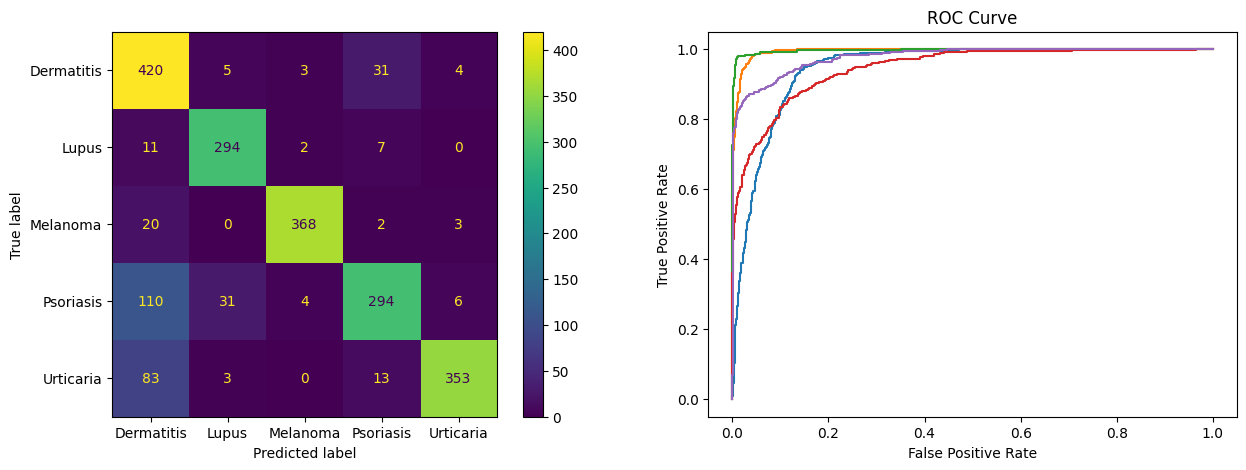

In [78]:
best_params = random_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9966
Specificity Score: 0.9966
Precision Score: 0.9966
F1 Score: 0.9966

Testing Results
Accuracy Score: 0.5177
Specificity Score: 0.5177
Precision Score: 0.6967
F1 Score: 0.5275

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       0.99      1.00      0.99      1677
   Psoriasis       1.00      0.99      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.64      0.33      0.44       463
       Lupus       0.95      0.54      0.68       314
    Me

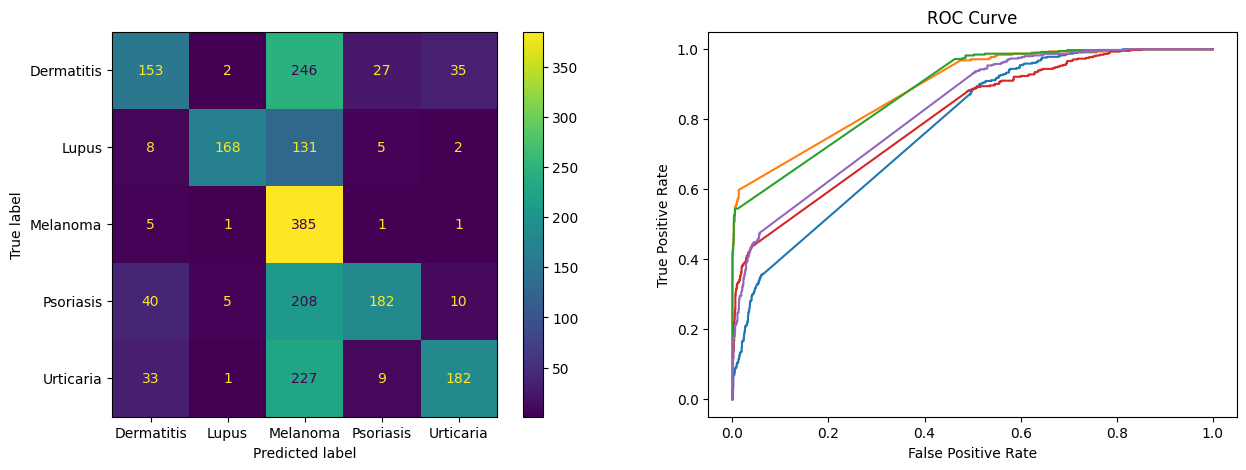

In [79]:
best_params = random_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.8858
Specificity Score: 0.8858
Precision Score: 0.8998
F1 Score: 0.8878

Testing Results
Accuracy Score: 0.8631
Specificity Score: 0.8631
Precision Score: 0.8786
F1 Score: 0.8649

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.93      0.81      1803
       Lupus       0.95      0.95      0.95      1355
    Melanoma       0.99      0.96      0.97      1677
   Psoriasis       0.89      0.77      0.83      1668
   Urticaria       0.97      0.83      0.90      1764

    accuracy                           0.89      8267
   macro avg       0.90      0.89      0.89      8267
weighted avg       0.90      0.89      0.89      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.70      0.92      0.80       463
       Lupus       0.92      0.92      0.92       314
    Melan

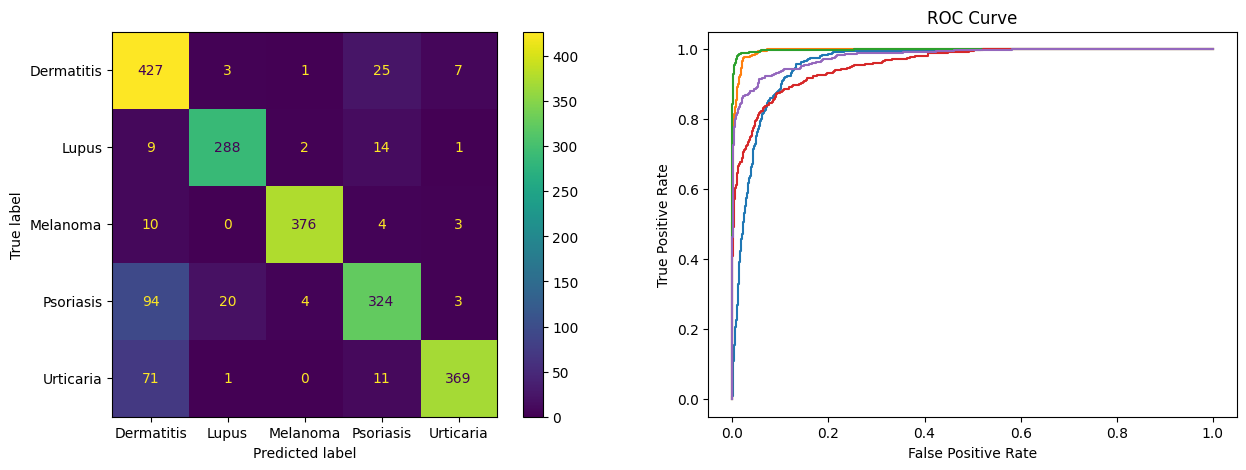

In [80]:
best_params = random_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [81]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

0.864921461869579


### Deep Learning

In [82]:
# Define number of unique words
words = set()

#### Recurrent Neural Network

In [83]:
# Create RNN model for text classification
vocab_size = 5000
embedding_dim = 32

rnn = Sequential(name="Basic_RNN")
rnn.add(Embedding(vocab_size, embedding_dim))
rnn.add(SimpleRNN(128, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(64, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(32, activation='relu'))
rnn.add(Dense(4, activation='softmax'))

rnn.build(input_shape=(None, X_train.shape[1]))

print(rnn.summary())

rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = rnn.fit(X_train.toarray(), y_train, epochs=10, validation_data=(X_test.toarray(), y_test))

NameError: name 'X_train' is not defined

#### Conv 1D

In [ ]:
# Create Conv1D model for text classification
conv1d = Sequential(name="Conv1D")
conv1d.add(Embedding(vocab_size, embedding_dim))
conv1d.add(Conv1D(128, 5, activation='relu'))
conv1d.add(GlobalMaxPooling1D())
conv1d.add(Dense(64, activation='relu'))
conv1d.add(Dense(4, activation='softmax'))

conv1d.build(input_shape=(None, X_train.shape[1]))

print(conv1d.summary())

#### LSTM

In [ ]:
# Create LSTM model for text classification
lstm = Sequential(name="LSTM")
lstm.add(Embedding(vocab_size, embedding_dim))
lstm.add(LSTM(32))
lstm.add(Dropout(0.4))
lstm.add(Dense(4, activation='softmax'))

lstm.build(input_shape=(None, X_train.shape[1]))

print(lstm.summary())

#### BILSTM

In [ ]:
# Create LSTM model for text classification
blstm = Sequential(name="Bi_LSTM")
blstm.add(Embedding(vocab_size, embedding_dim))
blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
blstm.add(Dropout(0.4))
blstm.add(Bidirectional(LSTM(32)))
blstm.add(Dropout(0.2))
blstm.add(Dense(64, activation='relu'))
blstm.add(Dropout(0.1))
blstm.add(Dense(4, activation='softmax'))

blstm.build(input_shape=(None, X_train.shape[1]))

print(blstm.summary())
